In [44]:
import sys 
sys.path.append("/scratch/m/murray/dtolgay/")
from tools import functions_readfiles


import numpy as np 
import pandas as pd 
from tools import readsnap, readsnap_FIREBox, readsnap_tripleLatte, constants  # tools directory is in the appended system directory
from tools.filter_rotate_galaxy import filter_rotate_galaxy

import matplotlib.pyplot as plt 
import matplotlib

import h5py


In [2]:
def read_firebox(
    snap_dir_file_path, 
    snapshot_number,
    simulation_name,
    file_number
    ):

    # Reading the header
    print('Reading header')
    header_info = readsnap_FIREBox.readsnap(
        sdir=snap_dir_file_path, 
        snum=snapshot_number, 
        simulation_name=simulation_name, 
        file_number=file_number, 
        ptype=0, 
        header_only=1
    )

    hubble      = header_info['hubble']
    redshift    = header_info['redshift']   
    time        = header_info['time']  

    # TODO: Delete
    print("header info:")
    print(header_info)

    # Reading the gas_particles
    print('\nReading gas_particles')
    gas_particles    = readsnap_FIREBox.readsnap(
        sdir=snap_dir_file_path, 
        snum=snapshot_number, 
        simulation_name=simulation_name, 
        file_number=file_number, 
        ptype=0, 
        cosmological=1
    )
    # Reading the star particles
    print('\nReading star_particles')    
    star_particles   = readsnap_FIREBox.readsnap(
        sdir=snap_dir_file_path, 
        snum=snapshot_number, 
        simulation_name=simulation_name, 
        file_number=file_number, 
        ptype=4, 
        cosmological=1
    )   

    return gas_particles, star_particles, header_info



# Main

In [3]:
%%time

# snapshot_number = 344     # z = 1.0
snapshot_number = 1200     # z = 0.0

snap_dir_file_path = "/scratch/m/murray/dtolgay/firebox/FB15N1024"

snapshot_number = '%03d' %snapshot_number
# simulation_name = "FB15N1024"  

gas_particles  = readsnap.readsnap(snap_dir_file_path, snapshot_number, 0, cosmological=1)
star_particles = readsnap.readsnap(snap_dir_file_path, snapshot_number, 4, cosmological=1)

print(gas_particles.keys())




npart_file:  [12143548 15567940        0        0  3279436        0]
npart_total: [ 861327031 1073741824          0          0  218857157          0]
npart_file:  [12143548 15567940        0        0  3279436        0]
npart_total: [ 861327031 1073741824          0          0  218857157          0]
dict_keys(['k', 'p', 'v', 'm', 'id', 'u', 'rho', 'h', 'ne', 'nh', 'sfr', 'z'])
CPU times: user 3min 11s, sys: 6min 13s, total: 9min 25s
Wall time: 17min 13s


In [4]:
header_info = readsnap.readsnap(snap_dir_file_path, snapshot_number, 0, header_only=1)

hubble      = float(header_info['hubble'])
redshift    = float(header_info['redshift'])   
time        = float(header_info['time'])   

header_info


npart_file:  [12143548 15567940        0        0  3279436        0]
npart_total: [ 861327031 1073741824          0          0  218857157          0]


{'k': 0,
 'time': 1.0,
 'boxsize': 15000.0,
 'hubble': 0.6774,
 'npart': array([12143548, 15567940,        0,        0,  3279436,        0],
       dtype=int32),
 'npartTotal': array([ 861327031, 1073741824,          0,          0,  218857157,
                 0], dtype=uint32),
 'redshift': 0.0}

In [5]:
%%time

gas_particles_df = pd.DataFrame({
    'x': gas_particles['p'][:,0],  # kpc 
    'y': gas_particles['p'][:,1],  # kpc 
    'z': gas_particles['p'][:,2],  # kpc 
    'vx': gas_particles['v'][:,0],
    'vy': gas_particles['v'][:,1],
    'vz': gas_particles['v'][:,2],
    'mass': gas_particles['m'],
    'density': gas_particles['rho'],
    'smoothing_length': gas_particles['h'],
    'star_formation_rate': gas_particles['sfr'],
    'internal_energy': gas_particles['u'] * 1e6,  # Converted to [m^2 s^-2]
    'neutral_hydrogen_fraction': gas_particles['nh'],
    'electron_abundance': gas_particles['ne'],
    'metallicity': gas_particles['z'][:,0],
    'He_mass_fraction': gas_particles['z'][:,1]
    # You can add other fractions as needed
})


# Create dataframe for star particles
star_particles_df = pd.DataFrame({
    'x': star_particles['p'][:,0],
    'y': star_particles['p'][:,1],
    'z': star_particles['p'][:,2],
    'vx': star_particles['v'][:,0],
    'vy': star_particles['v'][:,1],
    'vz': star_particles['v'][:,2],
    'metallicity': star_particles['z'][:,0],
    'scale_factor': star_particles['age'],
    'mass': star_particles['m']
})

CPU times: user 2min 15s, sys: 2min 28s, total: 4min 43s
Wall time: 4min 44s


Plotting galaxy


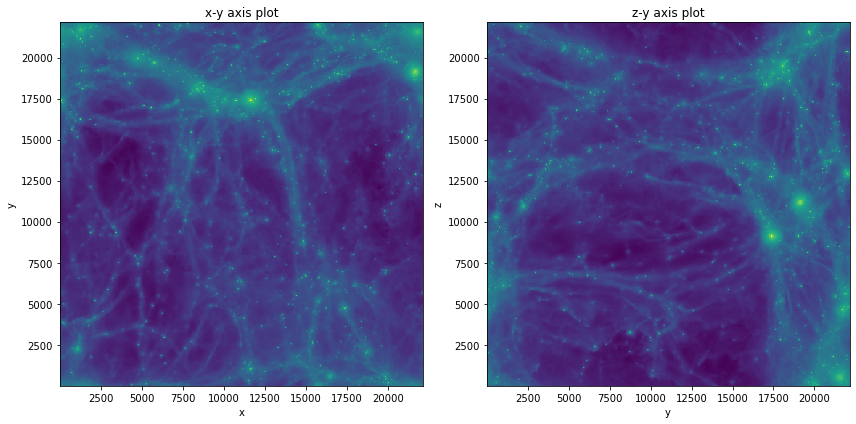

In [6]:
#################################### Plot

print("Plotting galaxy")
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# First subplot: x-y axis plot
axs[0].hist2d(
    x=gas_particles_df["x"], 
    y=gas_particles_df["y"], 
    bins=500,
    norm=matplotlib.colors.LogNorm(),
)
axs[0].set_title('x-y axis plot')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Second subplot: z-y axis plot
axs[1].hist2d(
    x=gas_particles_df["y"],  # Use the 'y' column for the x-axis
    y=gas_particles_df["z"],  # Keep the 'z' column for the y-axis
    bins=500,
    norm=matplotlib.colors.LogNorm(),
#     range=[[-R_max, R_max], [-R_max, R_max]]
)
axs[1].set_title('z-y axis plot')
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')

# Show the figure
plt.tight_layout()


# Reading the cloudy gas particle of the most massive halo to compare

In [29]:
%%time
import importlib
importlib.reload(functions_readfiles)

cloudy_gas_particles = functions_readfiles.read_cloudy_gas_particles(
        galaxy_name = "gal0", 
        galaxy_type = "firebox", 
        redshift = "0.0", 
        directory_name = "voronoi_1e6",
        base_fdir = "/scratch/m/murray/dtolgay/post_processing_fire_outputs/skirt/runs_hden_radius"
    )

# Read star particles 
comprehensive_star_particles = functions_readfiles.read_comprehensive_star_particles(
        galaxy_name = "gal0", 
        galaxy_type = "firebox", 
        redshift = "0.0", 
        directory_name = "voronoi_1e6",
        base_fdir = "/scratch/m/murray/dtolgay/post_processing_fire_outputs/skirt/runs_hden_radius"
    )

CPU times: user 59.9 s, sys: 3.08 s, total: 1min 2s
Wall time: 1min 3s


# Read the AHF files

In [8]:
fdir = "/scratch/m/murray/dtolgay/firebox/FB15N1024/analysis/AHF/halo_new/1200"
file_name = "FB15N1024.z0.000.AHF_halos"

column_names = [
    "ID", "hostHalo", "numSubStruct", "Mvir", "npart", "Xc", "Yc", "Zc", "VXc", "VYc", "VZc",
    "Rvir", "Rmax", "r2", "mbp_offset", "com_offset", "Vmax", "v_esc", "sigV", "lambda", "lambdaE",
    "Lx", "Ly", "Lz", "b", "c", "Eax", "Eay", "Eaz", "Ebx", "Eby", "Ebz", "Ecx", "Ecy", "Ecz",
    "ovdens", "nbins", "fMhires", "Ekin", "Epot", "SurfP", "Phi0", "cNFW", "n_gas", "M_gas",
    "lambda_gas", "lambdaE_gas", "Lx_gas", "Ly_gas", "Lz_gas", "b_gas", "c_gas", "Eax_gas",
    "Eay_gas", "Eaz_gas", "Ebx_gas", "Eby_gas", "Ebz_gas", "Ecx_gas", "Ecy_gas", "Ecz_gas",
    "Ekin_gas", "Epot_gas", "n_star", "M_star", "lambda_star", "lambdaE_star", "Lx_star",
    "Ly_star", "Lz_star", "b_star", "c_star", "Eax_star", "Eay_star", "Eaz_star", "Ebx_star",
    "Eby_star", "Ebz_star", "Ecx_star", "Ecy_star", "Ecz_star", "Ekin_star", "Epot_star"
]

halos = pd.DataFrame(
    np.loadtxt(f"{fdir}/{file_name}"),
    columns=column_names
)

# Reorder the dataframe according to the Mvir 
halos = halos.sort_values(by="Mvir", ascending=False)

In [9]:
np.log10(halos["Mvir"])

halos.iloc[0:100]

,ID,hostHalo,numSubStruct,Mvir,npart,Xc,Yc,Zc,VXc,VYc,...,Eay_star,Eaz_star,Ebx_star,Eby_star,Ebz_star,Ecx_star,Ecy_star,Ecz_star,Ekin_star,Epot_star
0,0.0,-1.0,2766.0,1.196040e+13,83812059.0,14711.058140,12986.948490,7614.448071,-20.50,18.82,...,0.094888,0.818304,0.823296,-0.030950,-0.566768,-0.028453,0.995007,-0.095666,6.074850e+16,-1.800580e+17
1,1.0,-1.0,2042.0,9.190950e+12,67557623.0,7908.847332,11816.418171,6188.743114,-19.79,39.51,...,-0.490304,-0.040646,0.354006,0.681670,-0.640317,0.341657,0.543073,0.767035,6.341500e+16,-2.032070e+17
2,2.0,-1.0,1838.0,8.386820e+12,60795088.0,14807.960987,14623.553753,362.226963,81.54,-1.85,...,-0.043943,0.376260,-0.361423,0.195104,0.911761,0.113475,0.979798,-0.164681,4.420600e+16,-1.471110e+17
3,3.0,-1.0,1066.0,4.844970e+12,35496909.0,873.863697,14724.276066,3167.645931,23.02,-48.64,...,0.304905,0.948012,0.982425,0.128191,-0.135674,-0.162894,0.943716,-0.287863,4.089500e+16,-1.271980e+17
5,5.0,-1.0,921.0,4.410250e+12,28317632.0,3228.571415,13545.219898,123.560429,35.76,-24.14,...,0.461016,-0.152426,-0.437838,0.884150,0.163022,0.209923,-0.075776,0.974777,1.169040e+16,-4.427170e+16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,89.0,9.0,41.0,1.720080e+11,1345729.0,943.608284,14193.806648,1338.715553,53.01,89.96,...,0.660330,-0.633631,0.861722,0.506994,-0.019824,-0.308157,0.554005,0.773381,1.907560e+14,-5.983480e+14
99,99.0,-1.0,94.0,1.715440e+11,1224997.0,3584.046364,13845.162392,14485.316277,-42.95,-272.76,...,-0.494011,-0.280438,0.316296,-0.011565,0.948590,0.471857,0.869379,-0.146736,7.867230e+13,-2.917100e+14
95,95.0,-1.0,92.0,1.708310e+11,1268860.0,7711.572647,11129.236221,9174.127579,-7.03,68.31,...,0.305759,0.901825,-0.943692,-0.029518,0.329507,-0.127369,0.951651,-0.279530,8.436300e+13,-3.254840e+14
124,124.0,-1.0,56.0,1.705800e+11,968519.0,9810.748100,5486.397743,12858.738899,95.82,-40.21,...,-0.428541,0.870961,-0.694657,0.550771,0.462712,0.677991,0.716243,0.165299,2.720800e+13,-1.212240e+14


## Find the gas particles in each halo

In [58]:
%%time

import functions_AHF

import importlib
importlib.reload(functions_AHF)

# Initiate an empty array to store the halos
halos_of_interest = []

# Find the first 100 halos 
for row, halo in halos.iloc[0:100].iterrows():

    x_center = halo['Xc'] # kpc/h
    y_center = halo['Yc'] # kpc/h
    z_center = halo['Zc'] # kpc/h
    rvir = halo['Rvir'] # kpc/h
    mvir = halo["Mvir"]
    
    # The positions and mass of the Halo is in comoving units. To make everything on physical units the below code is written
    x_center = x_center * time/hubble     # [kpc]
    y_center = y_center * time/hubble     # [kpc]
    z_center = z_center * time/hubble     # [kpc]  
    rvir = rvir * time/hubble     # [kpc]      
    mvir = mvir * 1/hubble # [Msolar]
    
    halos_of_interest.append(
        {
            "x": x_center,
            "y": y_center,
            "z": z_center,
            "rvir": rvir,
            "mvir": mvir,
        }
    )
    
    # TODO: Change it to rvir 
    rmax = 50 # kpc 
    filtered_gas_particles = functions_AHF.filter_particles(particles_df = gas_particles_df, x_halo = x_center, y_halo = y_center, z_halo = z_center, rmax = rmax)
    filtered_star_particles = functions_AHF.filter_particles(particles_df = star_particles_df, x_halo = x_center, y_halo = y_center, z_halo = z_center, rmax = rmax)

    # Change the origin of the particles 
    filtered_gas_particles = functions_AHF.change_origin(
        particles = filtered_gas_particles.copy(),
        x_halo_center = x_center, 
        y_halo_center = y_center, 
        z_halo_center = z_center,
    )
    
    filtered_star_particles = functions_AHF.change_origin(
        particles = filtered_star_particles.copy(), 
        x_halo_center = x_center, 
        y_halo_center = y_center,
        z_halo_center = z_center, 
    )
    
    # Reconstruct the dictionary to write the file 
    reconstructed_gas_particles = {
        'p': filtered_gas_particles[['x', 'y', 'z']].to_numpy(),  # shape (N, 3)
        'v': filtered_gas_particles[['vx', 'vy', 'vz']].to_numpy(),  # shape (N, 3)
        'm': filtered_gas_particles['mass'].to_numpy(),  # shape (N,)
        'rho': filtered_gas_particles['density'].to_numpy(),
        'h': filtered_gas_particles['smoothing_length'].to_numpy(),
        'sfr': filtered_gas_particles['star_formation_rate'].to_numpy(),
        'u': (filtered_gas_particles['internal_energy'] / 1e6).to_numpy(),  # reverse conversion
        'nh': filtered_gas_particles['neutral_hydrogen_fraction'].to_numpy(),
        'ne': filtered_gas_particles['electron_abundance'].to_numpy(),
        'z': filtered_gas_particles[['metallicity', 'He_mass_fraction']].to_numpy()  # shape (N, 2)
    }
    
    reconstructed_star_particles = {
        'p': filtered_star_particles[['x', 'y', 'z']].to_numpy(),         # shape (N, 3)
        'v': filtered_star_particles[['vx', 'vy', 'vz']].to_numpy(),      # shape (N, 3)
        'z': filtered_star_particles[['metallicity']].to_numpy(),         # shape (N, 1) — or (N,) depending on original
        'age': filtered_star_particles['scale_factor'].to_numpy(),        # shape (N,)
        'm': filtered_star_particles['mass'].to_numpy()                   # shape (N,)
    }    
    
    # Save galaxies into a hdf5 file
    file_name = f"gal_{row}.hdf5"
    with h5py.File(f'z0/{file_name}', 'w') as f:
        gas_group = f.create_group('gas')
        for key, value in reconstructed_gas_particles.items():
            gas_group.create_dataset(key, data=value)

        stars_group = f.create_group('star')
        for key, value in reconstructed_star_particles.items():
            stars_group.create_dataset(key, data=value)
    
    print(f"{file_name} written!")
            
    # Delete below if statement. It is done for debugging.
    if row >= 0:
        break 
    
    
halos_of_interest = pd.DataFrame(halos_of_interest)
    
    

gal_0.hdf5 written!
CPU times: user 4min 42s, sys: 45.5 s, total: 5min 28s
Wall time: 1min 29s


### Comparing filtered_gas_particles with the cloudy_gas_particles

In [46]:
# sum(filtered_gas_particles['mass']*1e10) / 1e11
sum(filtered_star_particles['mass']*1e10) / 1e11

4.519348969800887

In [47]:
# sum(cloudy_gas_particles['mass']) / 1e11
sum(comprehensive_star_particles['mass'] / 1e11)

3.2086079173988824

Plotting galaxy


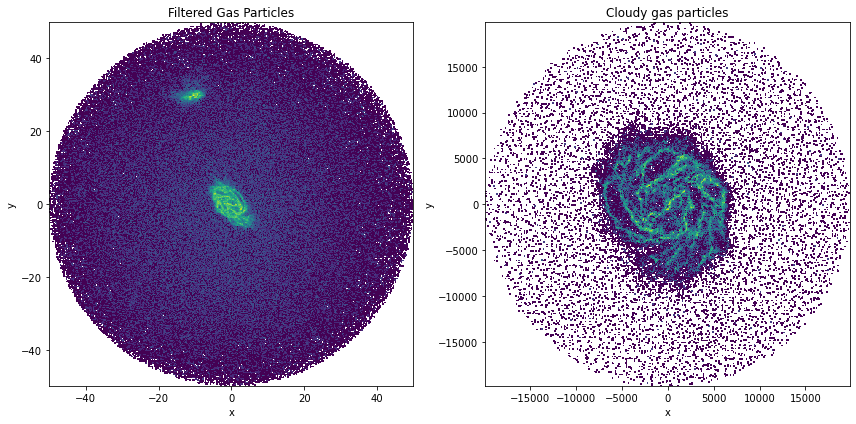

In [48]:
#################################### Plot

print("Plotting galaxy")
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# First subplot: x-y axis plot
axs[0].hist2d(
    x=filtered_gas_particles["x"], 
    y=filtered_gas_particles["y"], 
    bins=500,
    norm=matplotlib.colors.LogNorm(),
)
axs[0].set_title('Filtered Gas Particles')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Second subplot: z-y axis plot
axs[1].hist2d(
    x=cloudy_gas_particles["x"],  # Use the 'y' column for the x-axis
    y=cloudy_gas_particles["y"],  # Keep the 'z' column for the y-axis
    bins=500,
    norm=matplotlib.colors.LogNorm(),
#     range=[[-R_max, R_max], [-R_max, R_max]]
)
axs[1].set_title('Cloudy gas particles')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

# Show the figure
plt.tight_layout()


Plotting galaxy


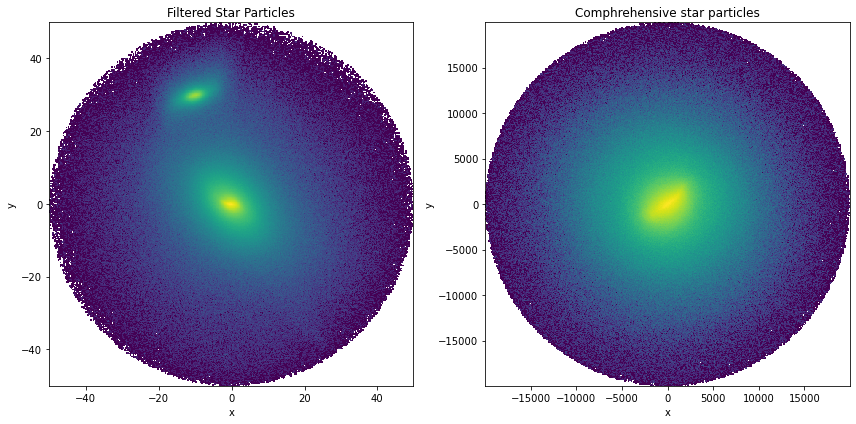

In [49]:
#################################### Plot

print("Plotting galaxy")
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# First subplot: x-y axis plot
axs[0].hist2d(
    x=filtered_star_particles["x"], 
    y=filtered_star_particles["y"], 
    bins=500,
    norm=matplotlib.colors.LogNorm(),
)
axs[0].set_title('Filtered Star Particles')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

axs[1].hist2d(
    x=comprehensive_star_particles["x"],  # Use the 'y' column for the x-axis
    y=comprehensive_star_particles["y"],  # Keep the 'z' column for the y-axis
    bins=500,
    norm=matplotlib.colors.LogNorm(),
#     range=[[-R_max, R_max], [-R_max, R_max]]
)
axs[1].set_title('Comphrehensive star particles')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

# Show the figure
plt.tight_layout()


# Read the file 

In [60]:
file_name = "gal_0.hdf5"

gas_particles = {}
star_particles = {}

with h5py.File(f'z0/{file_name}', 'r') as f:
    for key in f['gas']:
        gas_particles[key] = f['gas'][key][:]
    for key in f['star']:
        star_particles[key] = f['star'][key][:]


In [63]:
# Create dataframe
importlib.reload(functions_AHF)

gas_particles_read = functions_AHF.create_df_from_read_hdf5(particles = gas_particles, particle_type="gas")
star_particles_read = functions_AHF.create_df_from_read_hdf5(particles = star_particles, particle_type = "star")